### Loading packages and setting up plot parameters

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import time
from MediumAPI import mediumparser

In [2]:
%matplotlib inline
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

### Retrieving metadata from articles published from January to June 2018

The Data is loaded into a pandas Dataframe. Descriptive information is printed to review the dataset content.

In [3]:
data_dir = '../data/'
filename = 'Final_Postdf_NoText_Jan2018_June2018.p'
post_df = pickle.load(open(data_dir+filename,'rb'))

In [4]:
print("There are", len(post_df), "articles in the dataset")
print("The number of claps articles receive range from", min(post_df.clap_count),"to", max(post_df.clap_count))
print("The number of claps has a mean of", '%.2f' % post_df['clap_count'].mean(), "and a median of",  '%.2f' % post_df['clap_count'].median())
print("There are", len(post_df.loc[post_df.clap_count==0]), "articles with 0 claps")
print("The number of claps 80% quantile is", '%.2f' % post_df['clap_count'].quantile(0.8))


There are 244749 articles in the dataset
The number of claps articles receive range from 0 to 203361
The number of claps has a mean of 331.23 and a median of 4.00
There are 91232 articles with 0 claps
The number of claps 80% quantile is 107.00


We can see that the distribution is skewed and decreases rapidly with the number of claps. Most articles receive a low number of claps. This is an inequal distribution and can be expressed with a Pareto model. 

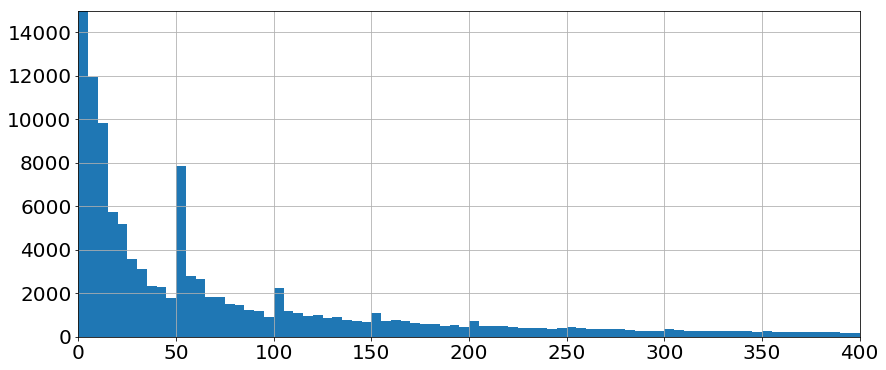

In [5]:
post_df['clap_count'].hist(bins = range(0,500,5), figsize=(14,6))
plt.xlim([0,400])
plt.ylim([0,15000])
plt.savefig('Success_dataset1.png')

There is large **applause inequality**. We can visualize the inequality better using a Lorenz curve and identify that 10% of the articles receive 90% of the applause.   

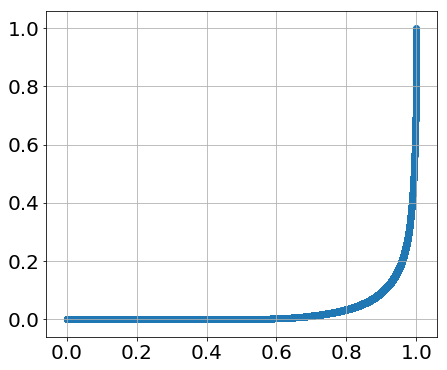

In [6]:
def lorenz_curve(claps):
    clap_lorenz = claps.cumsum()/claps.sum()
    clap_lorenz.index = range(len(clap_lorenz))
    plt.figure(figsize=(7,6))
    plt.grid(True)
    plt.scatter(clap_lorenz.index/len(clap_lorenz),clap_lorenz)
    
lorenz_curve(post_df.clap_count.sort_values())
plt.savefig('Pareto_Lorenz.png')    

### Defining a applause success
Due to this inequality distribution, we select a top quantile value as a target for success. We choose 80% to follow the traditional Pareto rule 80/20. However, different topics have different popularity distribution and different quantiles.
Let's see the split of non zero claps vs zero claps in the first dataset.

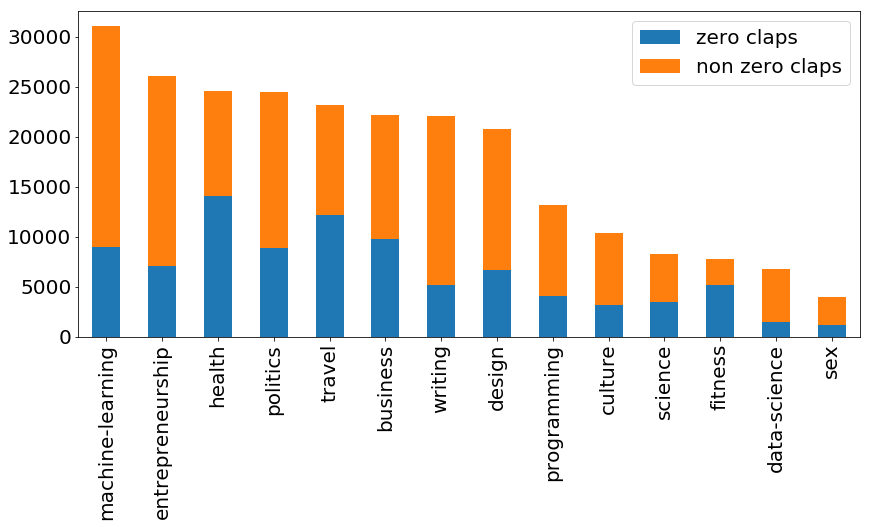

In [7]:
tag_df = pd.DataFrame()
tag_df['total_articles'] = post_df['post_tags'].value_counts()
tag_df['with_zero_claps'] = post_df.loc[post_df.clap_count==0,'post_tags'].value_counts()
tag_df['non_zero_claps'] = post_df.loc[post_df.clap_count>0,'post_tags'].value_counts()
tag_df[['with_zero_claps','non_zero_claps']].plot.bar(stacked=True, figsize=(14,6))
plt.legend(['zero claps','non zero claps'])
#plt.savefig('Dataset1_topics.png')   

In [8]:
100*tag_df['with_zero_claps']/tag_df['total_articles']

machine-learning    28.987468
entrepreneurship    27.025370
health              57.301950
politics            36.143003
travel              52.373356
business            44.206202
writing             23.266452
design              32.255114
programming         30.667678
culture             30.977791
science             41.593347
fitness             66.293436
data-science        20.961595
sex                 30.710853
dtype: float64

The percentage of zero claps is higher in travel and fitness articles. While data science and machine learning have the least zero clapped articles.

### Looking at the evolution of claps over time
Since the number of claps changes over time, it is important to understand how the number of claps increases with the age of the article. A plot of the first target quantile level for the first 50 days shows that the number of claps increases during the first 30 days but then it reaches a steady value.

In [9]:
daily_stats = post_df[['post_id','archive_date']].groupby('archive_date').count()
daily_stats['clap_mean'] = post_df[['clap_count','archive_date']].groupby('archive_date').mean().values
daily_stats['q80'] = post_df[['clap_count','archive_date']].groupby('archive_date').quantile([0.8]).values

In [10]:
startdate = dt.datetime.strptime(daily_stats.index[0],'%Y/%m/%d')
enddate = dt.datetime.strptime(daily_stats.index[-1],'%Y/%m/%d')
def calculate_age(strdate,enddate):
    xdate = dt.datetime.strptime(strdate,'%Y/%m/%d')
    return (enddate-xdate).days
daily_stats['age'] = [calculate_age(strdate, enddate) for strdate in daily_stats.index]

In [11]:
plotdf = daily_stats[['age','q80']].copy().sort_values(by=['age'])
plotdf.index = plotdf.age
plotdf.drop('age',axis=1,inplace=True)
plotdf['7day_mean'] = plotdf['q80'].rolling(7, min_periods=1).mean()

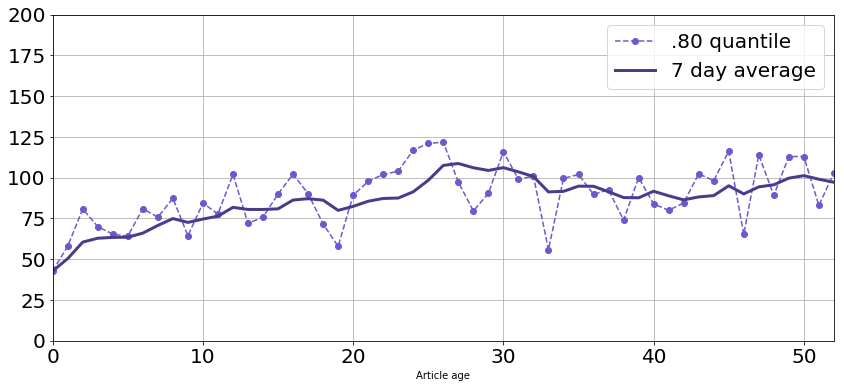

In [12]:
pltcolor1 = 'slateblue'
pltcolor2 = 'darkslateblue'
plt.figure(figsize=(14,6))
plotdf.q80.plot(marker='o',linestyle = '--', color = pltcolor1)
plotdf.q80.rolling(7, min_periods=1).mean().plot(color = pltcolor2, lw=3)
plt.ylim([0,200])
plt.xlim([0,52])
plt.xlabel('Article age')
plt.grid(True)
plt.legend(['.80 quantile','7 day average'])
plt.savefig('q80_age.png')  

### Topic overlapping and topic selection
Some articles may appear in different topics. This is because writers use tags of their choice for their articles. To focus on data for particular topics, Topic overlapping is a challenge in this project.

In [13]:
#%% Analyzing topic overlapping
popular_tags = ['health','writing','design','entrepreneurship','politics','programming','business','data-science','machine-learning','artificial-intelligence','culture','sex','travel','fitness','science']
tag_df = pd.DataFrame()
tag_df['total_count'] = post_df.post_tags.value_counts()
duplicates_df = post_df.loc[post_df.post_id.duplicated(keep=False),['post_id','post_tags']]
duplicates_df.index = duplicates_df['post_id']
duplicates_df.drop(['post_id'],axis=1, inplace=True)
tag_df['duplicated'] = duplicates_df.post_tags.value_counts()
tag_df['dup_percent'] = 100*tag_df['duplicated']/tag_df['total_count']
tag_df

,total_count,duplicated,dup_percent
machine-learning,31041,13969,45.001772
entrepreneurship,26094,7943,30.439948
health,24514,4377,17.855103
politics,24475,3644,14.888662
travel,23195,1946,8.389739
business,22153,7285,32.884937
writing,22079,4909,22.233797
design,20775,2268,10.916968
programming,13180,1353,10.265554
culture,10401,3011,28.949140


The tag machine-learning will be merged with artificial intelligence. This tag will have a high number of duplicated articles. This tag shares many articles with the data-science tag.   
The business and entrepreneurship tags share a large number of articles as well.   
Many fitness articles are included in the health tag. To focus our text scraping effort, these final tags are selected:
'health','writing','design','politics','programming','business','machine-learning' and 'travel'

In [14]:
post_df.loc[post_df[post_df.post_tags=='artificial-intelligence'].index]['post_tags'] = 'machine-learning'
drop_tags = ['entrepreneurship','data-science','culture','sex','fitness','science']
for tag in drop_tags:
    post_df.drop(post_df[post_df.post_tags==tag].index, axis=0,inplace=True)

In [15]:
final_tags = ['health','writing','design','politics','programming','business','machine-learning','travel']
tag_df = pd.DataFrame()
tag_df['total_count'] = post_df.post_tags.value_counts()
duplicates_df = post_df.loc[post_df.post_id.duplicated(keep=False),['post_id','post_tags']]
duplicates_df.index = duplicates_df['post_id']
duplicates_df.drop(['post_id'],axis=1, inplace=True)
tag_df['duplicated'] = duplicates_df.post_tags.value_counts()
tag_df['dup_percent'] = 100*tag_df['duplicated']/tag_df['total_count']
tag_df

,total_count,duplicated,dup_percent
machine-learning,30069,10576,35.172437
health,22359,1189,5.317769
politics,22267,2237,10.046257
travel,21548,997,4.626880
writing,20056,3371,16.807938
business,19830,2253,11.361573
design,19283,1509,7.825546
programming,12375,954,7.709091


To scrape text content for only unique articles, we drop duplicated articles.

In [16]:
unique_post_df = post_df.drop_duplicates('post_id',keep='first').copy()
unique_post_df.index = range(len(unique_post_df))
pickle.dump(unique_post_df,open('unique_post_df.p','wb'))

In [17]:
print("There are", len(unique_post_df), "unique articles in the dataset")
print("The number of claps articles receive range from", min(unique_post_df.clap_count),"to", max(unique_post_df.clap_count))
print("The number of claps 80% quantile is", '%.2f' % unique_post_df['clap_count'].quantile(0.8))

There are 155540 unique articles in the dataset
The number of claps articles receive range from 0 to 203361
The number of claps 80% quantile is 83.00


Another observed challenge is that articles get reposted within their tags. Writers use this reposting to drive readership.